In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [220]:
%matplotlib inline

import os
import h5py
import json
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import zscore
from scipy import stats as scipystats
from scipy import signal
from sklearn import decomposition

from utils.psth import get_shuffled, get_spike_counts
from utils.neurosuite import get_unit_names_sorted
from utils.behavior import get_idxs_as_periods
from utils.states import get_state_as_periods
#from utils.events import get_sound_event_periods

In [354]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

animal      = session.split('_')[0]
s_path = os.path.join(source, animal, session)
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')

In [355]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        
spike_times_all = spike_times.copy()

In [465]:
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

speed_max = 0.04
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

# success stays
idxs_tgt_succ = []
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
for tgt_rec in tgt_mx_succ:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

idxs_sil_run_ev = np.intersect1d(idxs_sil_ev, idxs_run_ev)
idxs_bgr_run_ev = np.intersect1d(idxs_bgr_ev, idxs_run_ev)

In [357]:
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
tgt_succ_pos_mx = np.zeros([len(tgt_mx_succ), 4])
for i, tgt_rec in enumerate(tgt_mx_succ):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_pos_mx[i] = [tgt_rec[0], tgt_rec[1], x_pos.mean(), y_pos.mean()]
    
bgr_sta_long_mx, idxs_bgr_sta_long = get_state_as_periods(s_path, 'BGR', 'STA', None, 12)
sil_sta_long_mx, idxs_sil_sta_long = get_state_as_periods(s_path, 'SIL', 'STA', None, 12)
bgr_sta_AL_mx, idxs_bgr_sta_AL = get_state_as_periods(s_path, 'BGR', 'STA', 'AL', 12)
len(idxs_bgr_sta_long), len(idxs_sil_sta_long), len(idxs_bgr_sta_AL)

(460, 385, 421)

In [358]:
# MRL
MRL_mx = np.zeros([len(unit_names), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_names):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [359]:
# mean firing rate
FR_mx = np.zeros([len(unit_names), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_names):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

## Unit filtering

In [360]:
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198'],
    '013608_ppcSIT_2025-01-15_14-56-18': ['2-166', '2-288', '3-258', '4-231'],
    '013608_ppcSIT_2025-01-20_09-38-20': ['2-160', '2-241', '3-221', '4-201']
}

# exclude some?
#for unit in special['013608_ppcSIT_2025-01-14_10-20-14']:
#    spike_times.pop(unit)

idxs_special = [unit_names.index(x) for x in special[session]]
print(f"{len(idxs_special)} units to be excluded as special")

# MRL criteria
pv_min = 0.2
MRL_min = 0.05
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_names)} units > 0.5Hz firing rate")
    
# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)
idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

idxs_mfr_spc = np.setdiff1d(idxs_mfr_min, idxs_special)

idxs_final_filt = idxs_mfr_spc
spike_times = {}
unit_ids = [unit_names[x] for x in idxs_final_filt]
for unit_id in unit_ids:
    spike_times[unit_id] = spike_times_all[unit_id]

print(f"{len(idxs_MRL_high)} units with phase locking")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")
print(f"{len(idxs_final_filt)} units selected")

4 units to be excluded as special
156 out of 213 units > 0.5Hz firing rate
38 units with phase locking
80 units have kind of no phase locking
152 units selected


## Unit activity matrix

In [361]:
# unit activity matrix
unit_mx_database = {}

In [362]:
# OPTION 1 - sound events binning
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

unit_mx = zscore(unit_mx, axis=1)
unit_mx_database[1] = unit_mx.T.copy()

unit_mx.shape

(152, 9599)

In [363]:
# OPTION 2 - few sound events unwrapped in the future
unwrap_count = 1  # plus one more event

t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])  # units, sound events
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)  # sound events, units

res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

unit_mx_database[2] = res.T.copy()

unit_mx.shape, res.shape

((152, 9599), (304, 9599))

## Build representation vectors

In [571]:
# select which unit activity matrix
unit_mx = unit_mx_database[1]

# select event types
event_mx = tgt_succ_pos_mx
#event_mx = sil_sta_long_mx
#event_mx = bgr_sta_long_mx

pulses_per_event = 12

In [203]:
# via PSTH
hw, bc = 0.25, 11

vectors1 = np.zeros([len(event_mx), len(unit_ids), bc // 2])  # event, unit, bin
for i, event in enumerate(event_mx):
    idxs_event  = np.arange(int(event[0]), int(event[0]) + pulses_per_event)
    event_times = sound_events[idxs_event][:, 0]
    
    for j, unit_name in enumerate(unit_ids):
        bins, psth = get_spike_counts(spike_times[unit_name], event_times, hw=hw, bin_count=bc)

        # scaling
        if not (psth == psth[0]).all():
            #scaled = (psth - np.min(psth)) / (np.max(psth) - np.min(psth))  # MinMax 
            scaled = scipystats.zscore(psth)  # z-score
        else:
            scaled = psth

        vectors[i][j] = psth[bc//2:]

In [556]:
# average representation of a pulse inside TGT success
vectors3 = np.zeros([len(event_mx), len(unit_ids)])  # event, unit, bin
for i, event in enumerate(event_mx):
    vector = unit_mx[int(event[0]):int(event[0]) + pulses_per_event]
    
    vectors3[i] = vector.mean(axis=0)

In [575]:
# the whole period of TGT success
vectors4 = np.zeros([len(event_mx), pulses_per_event, len(unit_ids)])  # event, unit, bin
for i, event in enumerate(event_mx):
    vector = unit_mx[int(event[0]) + 12:int(event[0]) + pulses_per_event + 12]
    
    vectors4[i] = vector
    
vectors4.shape

(46, 12, 152)

In [576]:
corr_tgt_mx = []

combs = list(itertools.combinations(range(len(event_mx)), 2))  # combinations of vector IDs
for idx_1, idx_2 in combs:
    v1 = vectors4[idx_1].flatten()
    v2 = vectors4[idx_2].flatten()

    corr = np.corrcoef(v1, v2)[0][1]
    dist = np.sqrt( (event_mx[idx_1][2] - event_mx[idx_2][2])**2 + (event_mx[idx_1][3] - event_mx[idx_2][3])**2 )
    time = np.abs(event_mx[idx_2][0] - event_mx[idx_1][0]) / 4  # in seconds

    # corr coeff, dist b/w targets, time b/w targets
    corr_tgt_mx.append(np.array([corr, dist, time]))
corr_tgt_mx = np.array(corr_tgt_mx)

-0.03431191421934025
-1.1168389419674523e-05


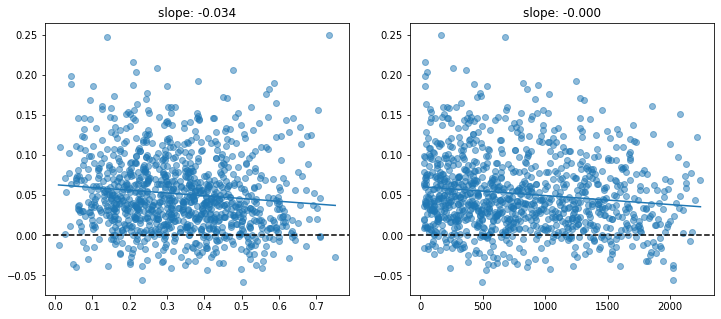

In [577]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axes):
    x = corr_tgt_mx[:, i+1]
    y = corr_tgt_mx[:, 0]
    
    lr_res = scipystats.linregress(x, y)
    sl, it = lr_res.slope, lr_res.intercept
    print(sl)
    
    ax.plot([x.min(), x.max()], [x.min()*sl + it, x.max()*sl + it])
    
    ax.scatter(corr_tgt_mx[:, i+1], corr_tgt_mx[:, 0], alpha=0.5)
    ax.axhline(0, ls='--', color='black')
    ax.set_title(f'slope: {sl:.3f}')

/tmp/ipykernel_43075/3303574352.py:2: RuntimeWarning: invalid value encountered in log
  ax.scatter(corr_tgt_mx[:, 1], corr_tgt_mx[:, 2], c=np.log(corr_tgt_mx[:, 0])/10, cmap='coolwarm')


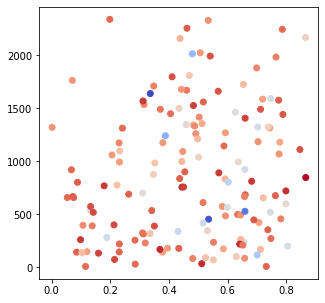

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(corr_tgt_mx[:, 1], corr_tgt_mx[:, 2], c=np.log(corr_tgt_mx[:, 0])/10, cmap='coolwarm')

## Progression within a target

In [544]:
offset = 6  # sec
bins_zise = 0.01  # 10 ms
bins = np.arange(0, offset + bins_zise, bins_zise)

# onsets of scores
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
pulse_times = sound_events[tgt_mx_succ[:, 0].astype(np.int32)][:, 0]

# # random onsets
# random_idxs = np.random.randint(0, len(sound_events) - len(tgt_mx_succ), len(tgt_mx_succ))
# pulse_times = sound_events[random_idxs][:, 0]

# random SIL onsets
# random_sil_idxs = [np.random.choice(idxs_sil_ev) for x in range(len(tgt_mx_succ))]
# pulse_times = sound_events[random_sil_idxs][:, 0]

tgt_psth_mx = []
for i, unit_name in enumerate(unit_ids):
    collected = []
    spk_times = spike_times[unit_name]
    for t_pulse in pulse_times:  # iterate over successful TGT stays
        selected = spk_times[(spk_times > t_pulse) & (spk_times < t_pulse + offset)]
        collected += [x for x in selected - t_pulse]
    collected = np.array(collected)
    
    counts, _ = np.histogram(collected, bins=bins)
    counts = counts / len(pulse_times) # * 1/((2. * hw)/float(bin_count - 1))
    counts = counts / (bins[1] - bins[0])  # divide by bin size to get firing rate
    
    counts = scipystats.zscore(counts)
    tgt_psth_mx.append(counts)
tgt_psth_mx = np.array(tgt_psth_mx)

In [545]:
peak_fr_pos = np.argmax(tgt_psth_mx, axis=1)
idxs_sort_tgt_psth_mx = np.argsort(peak_fr_pos)

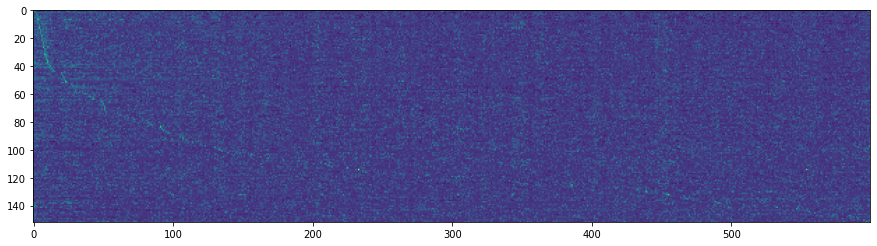

In [546]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(tgt_psth_mx[idxs_sort_tgt_psth_mx])
#ax.imshow(tgt_psth_mx[idxs_sort_tgt_psth_mx][120:])

In [533]:
ccr_test_mx = tgt_psth_mx
mid = 300
unit_count = len(tgt_psth_mx)
lag_matrix = np.zeros([unit_count, unit_count])
for i in range(unit_count):
    for j in range(unit_count):
        ccr = signal.correlate(ccr_test_mx[i], ccr_test_mx[j], mode='same')
        lag_matrix[i][j] = np.argmax(ccr[mid - 25:mid + 25]) - 25

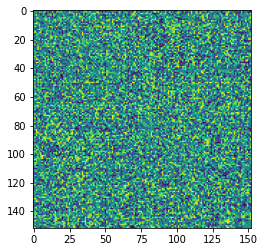

In [534]:
plt.imshow(lag_matrix)

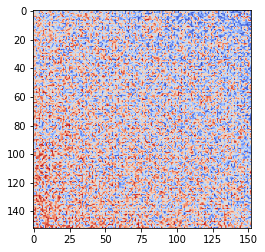

In [535]:
mean_lags = np.nanmean(lag_matrix, axis=1)
sort_order = np.argsort(mean_lags)
sorted_lag_matrix = lag_matrix[sort_order][:, sort_order]

plt.imshow(sorted_lag_matrix, cmap='coolwarm')

In [536]:
N = lag_matrix.shape[0]
sorted_lags = lag_matrix[np.ix_(sort_order, sort_order)]
sorted_lags = lag_matrix[sort_order][:, sort_order]
count = 0
total = 0
for i in range(N):
    for j in range(i + 1, N):
        total += 1
        if sorted_lags[i, j] < 0:
            count += 1

count / total 

0.5446148483792262

In [511]:
bins_tgt_psth = np.arange(0, 0.26, 0.01)

tgt_psth_single_mx = []
for i, neuron_idx in enumerate(sort_order):
    collected = []
    spikes = spike_times[unit_ids[neuron_idx]]
    for t_tgt in sound_events[idxs_tgt_ev][:, 0]:
        collected += list(spikes[(spikes >= t_tgt) & (spikes < t_tgt + 0.25)] - t_tgt)
    collected = np.array(collected)
    
    counts, _ = np.histogram(collected, bins=bins_tgt_psth)
    counts = counts / len(idxs_tgt_ev) # * 1/((2. * hw)/float(bin_count - 1))
    counts = counts / (bins[1] - bins[0])  # divide by bin size to get firing rate
    
    counts = scipystats.zscore(counts)
    tgt_psth_single_mx.append(counts)
tgt_psth_single_mx = np.array(tgt_psth_single_mx)

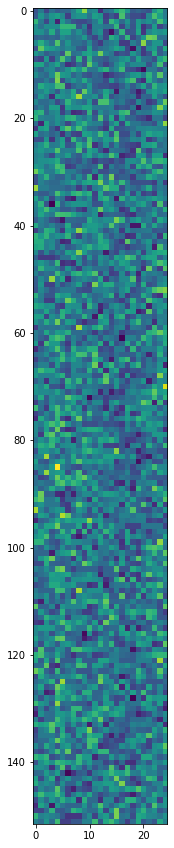

In [474]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(tgt_psth_single_mx)

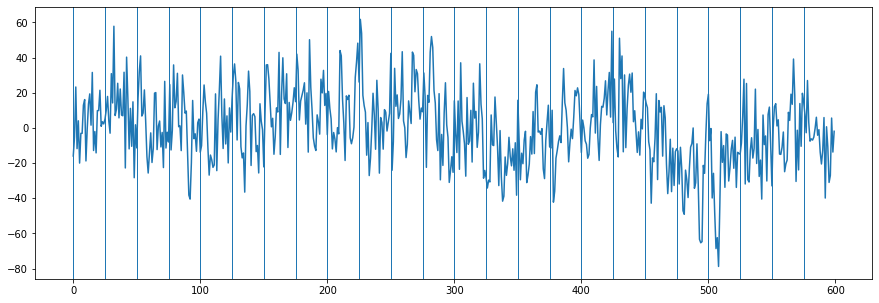

In [537]:
sig_tgt = tgt_psth_mx.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(sig_tgt)
for i in range(24):
    ax.axvline(i*25, lw=1)

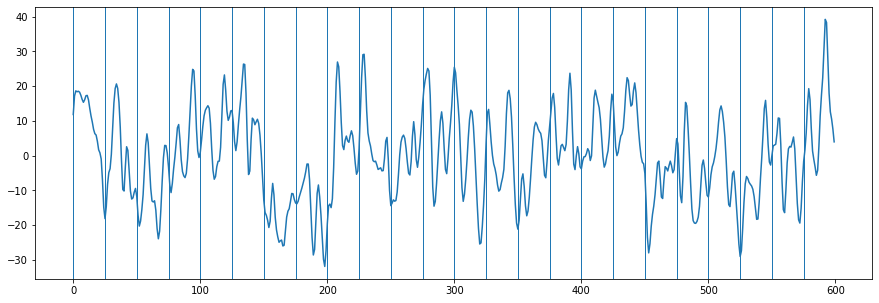

In [523]:
width = 10  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)

sig_smooth = np.convolve(sig_tgt, kernel, 'same') / kernel.sum()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(sig_smooth)
for i in range(24):
    ax.axvline(i*25, lw=1)

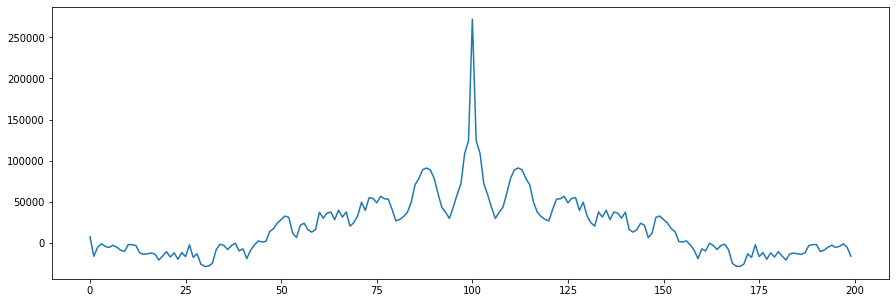

In [538]:
tgt_autocorr = signal.correlate(sig_tgt, sig_tgt, mode='same')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(tgt_autocorr[200:400])
#plt.plot(tgt_sig)

In [539]:
def get_power_spectrum(sig, s_rate=1000):
    FFT = np.fft.fft(sig)
    nyquist = s_rate / 2
    freqs = np.linspace(0, nyquist, int(len(sig)/2))
    half_FFT = FFT[:len(freqs)]
    complex_conjugate = np.conj(half_FFT)
    return freqs, half_FFT*complex_conjugate

In [540]:
fs = 100
cutoff = 1  # Hz
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist
b, a = signal.butter(10, normal_cutoff, btype='high', analog=False)
sig_filt = signal.filtfilt(b, a, sig_tgt)

freqs, powers = get_power_spectrum(sig_filt, s_rate=100)

In [541]:
n = len(sig_filt)
freqs = np.fft.rfftfreq(n, d=1/fs)  # one-sided frequency array
fft_vals = np.fft.rfft(sig_filt)
powers = np.abs(fft_vals) ** 2 / n  # power spectrum (normalized)

(0.0, 10.0)

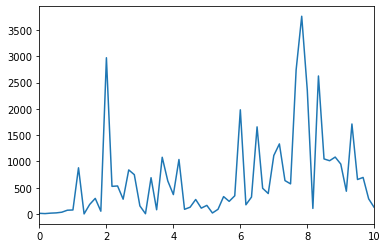

In [542]:
fig, ax = plt.subplots(1, 1)
ax.plot(freqs, powers)
ax.set_xlim(0, 10)

## Correlate whole targets

In [ ]:
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
pulse_times = sound_events[tgt_mx_succ[:, 0].astype(np.int32)][:, 0]

for t_pulse in pulse_times:  # iterate over successful TGT stays
    for unit
    selected = spk_times[(spk_times > t_pulse) & (spk_times < t_pulse + offset)]
    collected += [x for x in selected - t_pulse]